In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG

import mcint #pip install mcint
import random

In [2]:
#import dill
#dill.dump_session('fluorescence_calculations_env_3.db')
#dill.load_session('fluorescence_calculations_env_3.db')

# Version History

v 2.0:
    
    -added code which update's the detector's position and orientation in sample coordinates as beam angle of incidence changes such that the detector is static in user coordinates
    
v 3.0:

    -fixed a bug where the apex angle was calculated as arcsin(R/D) instead of arctan(R/D)

# Mathematical Prinicples

Consider a sample of infinite depth and area. This assumption is reasonable so long as the beam shape and sample size are such that the beam entirely hits the sample and nothing else.

We begin by defining three unit vectors $\hat{x}_{s}$, $\hat{y}_{s}$, and $\hat{z}_{s}$ which define what we will call the "sample coordinate system". The vector $\hat{y}_{s}$ defines a direction normal to the sample's surface. $\hat{x}_{s}$ and $\hat{z}_{s}$ both define unit vectors in the plane of the sample's surface. $\hat{x}_{s}$ defines the dimension of the illuminated rectangle which grows and shrinks as the beam's angle of incidence is varied; $\hat{z}_{s}$ defines the dimension of the illuminated rectangle which does not change as the beam's angle of incidence is varied.

At a typical XAFS beamline, $\hat{X}$ is taken as the direction of polarization of the beam, $\hat{Y}$ is taken as the vertical direction from the floor to the ceiling, and $\hat{Z}$ is taken as the direction of propagation of the beam. Herein this coordinate system is called the "standard coordinate system". When the sample's axis of rotation is $\hat{Y}$ (and the detector is therefore situated in the same plane as the ring and sample), our sample coordinate system has the following relationship to this standard coordinate system:
$$\huge{  \hat{x}_{s} =      \hat{X}sin(\theta) + \hat{Z}cos(\theta)                } $$
$$\huge{  \hat{y}_{s} =      \hat{X}cos(\theta) - \hat{Z}sin(\theta)                }$$
$$\huge{  \hat{z}_{s} =       \hat{Y}                              }$$
When the sample's axis of rotation is $\hat{X}$ (and the detector is therefore situated above or below the sample), our sample coordinate system's relationship to the standard coordinate system becomes:
$$\huge{   \hat{x}_{s} =      \hat{Y}sin(\theta) + \hat{Z}cos(\theta)                                                   }$$
$$\huge{  \hat{y}_{s} =      \hat{Y}cos(\theta) - \hat{Z}sin(\theta)                }$$
$$\huge{  \hat{z}_{s} =       \hat{X}                              }$$

Where $\theta$ is the beam's angle of incidence.

We then consider a parallelepiped which defines the illuminated volume within the sample. Because the beam is attenuated as it penetrates further into the sample, we arbitrarily cut the parallelepiped off at a depth where the attenuation is above 99%. This parallelepiped has four rectangular faces.

The origin of the sample coordinate system is taken to be the vertex of this parallelepiped closest to the beam source. There are two vertices which satisfy this condition, so we choose a vertex such that the $\hat{x}_s$ and $\hat{z}_s$ coordinates of all other vertices are positive (or zero). The center of the illuminated area therefore has sample coordinates of 

$$<\frac{w_{beam}}{2sin(\theta)}, 0, \frac{h_{beam}}{2}>$$

The position of the detector and its orientation are defined in the sample coordinate space. In these calculations, the detector is situated at a 90° angle with respect to the beam, and has a vertex in sample coordinates of 
$$<sin(\theta)d_{detector} +\frac{w_{beam}}{2sin(\theta)}, cos(\theta)d_{detector},\frac{h_{beam}}{2}>$$

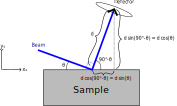

In [3]:
SVG(filename = "jupyter diagrams/detector origin.svg")

The detector's orientation must also be specified. We do so by considering a spherical coordinate system which uses identical x, y, and, z axes to the sample coordinate system. Two angles $\alpha$ and $\beta$ specify a direction in this coorinate system which defines a direction normal to the surface of the detector.

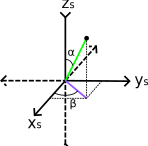

In [4]:
SVG(filename = "jupyter diagrams/spherical coordinate system.svg")

We define $\hat{z}_d$ as a unit vector in the direction specified by $\alpha$ and $\beta$. We can define $\hat{x}_d$ and $\hat{y}_d$ arbitrarily as any vectors which are perpendicular to $\hat{z}_d$ and each other. These vectors define a new coordinate system: "detector coordinates". The idea here is that because the surface of the detector is a circle, it will be relatively straightforward to sample points from the surface of the detector systematically in a coordinate system where the detector's center is the origin and the whole of the detector's surface lies in the xy plane. This will make things easier to calculate later down the line.

$\alpha$ and $\beta$ are calculated such that the surface normal from the center of the detector points directly at the center of the illuminated area. Because the $\hat{z}_s$ direction is perpendicular to the plane in which the detector moves relative to the sample surface, $\alpha$ is always taken to be $\frac{\pi}{2}$, which places the surface normals from both the sample in the detector in the same plane. $\beta$ is taken as 270° - $\theta$ to keep the detector pointed directly at the center of the illuminated region.

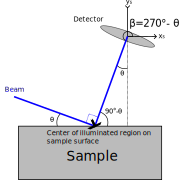

In [5]:
SVG(filename = "jupyter diagrams/detector orientation.svg")

We can then define a rotation matrix $M$ that allows us to convert a point from detector coordinates to sample coordinates
$$\begin{bmatrix}
    x_{d}[0]   & y_{d}[0] & z_{d}[0]  \\
    x_{d}[1]   & y_{d}[1] & z_{d}[1]  \\
    x_{d}[2]   & y_{d}[2] & z_{d}[2]  \\
\end{bmatrix}$$
and an inverse matrix $W = M^{-1}$ which allows us to convert a point from sample coordinates to detector coordinates.

Because the sample coordinate system and detector coordinate systems have different origins, coverting a point in one system to another requires us to first multiply by the appropriate transformation matrix, and then shift the position by the difference of the origins. 

We define below a useful function detector_coordinates_to_sample_coordinates. Because the detector is a circle, it is convenient to specify points on the surface of the detector using polar coodinates. These point must, by definition, lie in the xy plane of the detector coordinate system. The function detector_coordinates_to_sample_coordinates takes polar coordinates in detector space, converts them to cartesian detector coordinates, and then converts from cartesian detector coordinates to cartesian sample coordinates.

We also define functions for calculating the incoming and outgoing attenuation of a photon. Both are functions of the path length that a photon takes traveling into the sample and exiting the sample. To reach a point in the illuminated parallelepiped, an incoming photon must traverse a path of a length equal to the depth of the point divided by the sin of the photon's angle of incidence. To escape a point in the illuminated parallelepiped and reach a given point on the detector, a photon must traverse a length of sample equal to the distance between the two points times the depth of the point in the sample divided by the distance between the two points along the $\hat{y}_s$ axis. We do not consider the attenuation of the photon outside of the sample.

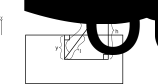

In [6]:
SVG(filename = "jupyter diagrams/outgoing photon attenuation.svg")

We formulate our integral over five dimentions. First, we consider each point in the illuminated parallelepiped, and the attenuation that is applied to the beam as it reaches a point with a given depth. This results in a triple integral over x, y, and z in the sample coordinate system. We imagine each point in the illuminated parallelepiped as a point source, and we consider each unique path that a fluoresced photon can traverse to reach the detector. Each escape path is uniquely associated with a point on the detector, so we can compute each path by integrating over the surface of the detector. We consider the intensity of the point source as falling off as the square of the distance to the point on the detector, and we consider the outgoing attenuation along each path. We also consider a cosine term which represents the diminishment in flux of photons as the photons strike the differential areas on the detector at incident angles off of normal. We throw in an $r$ term as is standard for polar integrals.

$$\large{ (photon flux) (quantum yield)\frac{1}{4\pi} \int_{z=0}^{z_{illum}} \int_{y=-\infty}^{0} \int_{x=-\frac{y}{tan(\theta)}}^{-\frac{y}{tan(\theta)}+x_{illum}}  (incoming attenuation)\frac{\mu_i}{sin(\theta)}  \int_{\phi = 0}^{2\pi}    \int_{r=0}^{R}  \frac{r cos(\gamma)}{distance^2} (outgoing attenuation)  dr d\phi dx dy dz                } $$

# Define Experimental Configuration Class

In [7]:
class experiment:
    def __init__(self, 
                theta = 6,
                R = np.sqrt(170/4/np.pi),
                beam_width = 3,
                beam_height = 1,
                photon_flow = 7.7E9,
                quantum_yield = 0.08,
                #alpha = np.pi/2,
                #beta = np.pi/2,
                detector_distance = 10,
                mu_T_Ef = 222.222,
                mu_T_E = 185.1852,
                mu_i = 2.8662,
                nmc = 50000,
                suppress_output = False,
                detector_above_sample = False):
        #we define here coordinates for the sample
        self.x_s = np.array([1, 0, 0]) # x is a unit vector on the sample's surface that defines the dimension of illuminated area which shrinks or elongates as the beam's angle of incidence is varied
        self.y_s = np.array([0, 1, 0]) # y is the direction normal to the sample surface
        self.z_s = np.array([0, 0, 1]) # z is a unit vector on the sample's surface that defines the dimension of illuminated area which does not change as the beam's angle of incidence is varied
        
        self.suppress_output = suppress_output
        
        self.theta = theta*np.pi/180
        
        self.R = R
        self.d = 2*self.R
        self.detector_distance = detector_distance
        
        #if the detector is situated above or below the sample (i.e. towards the ceiling or floor) then the beam's height will be spread out as theta changes
        if (detector_above_sample):
            self.z_illum = beam_width #in mm
            self.x_illum = beam_height/np.sin(self.theta) #in mm
        #if the detector is mounted in the same horizontal plane as the sample (as is typical), then the beam's width will be spread out as theta changes
        else:
            self.z_illum = beam_height #in mm
            self.x_illum = beam_width/np.sin(self.theta) #in mm
            

        self.photon_flow = photon_flow #photons/second
        self.photon_flux = self.photon_flow/self.z_illum/self.x_illum #photons/s/mm^2

        self.quantum_yield = quantum_yield
        
        
        #DETECTOR POSITION (in sample coordinates) CHANGES AS YOU CHANGE THETA (if the detector is fixed in labratory coordinates)
        self.x_d = np.sin(self.theta)*detector_distance+self.x_illum/2 #mm
        self.y_d = np.cos(self.theta)*detector_distance #mm
        self.z_d = self.z_illum/2 #mm
        
        #check to make sure the detector is not clipping into the sample
        if self.y_d - np.sin(self.theta)*self.R <= 0:
            raise ValueError('Detector clips into sample slab!')
        
        self.p_d = np.array([self.x_d, self.y_d, self.z_d])

        #angle at which detector is tilted
        #from a beamline user's point of view, the detector and beam are static, and the sample's position and orientation are adjusted.
        #in our calculations, we consider the sample as being static and the beam/detector as being adjusted.
        #the detector should typically be 90° from the beam. Since our picture is of a static sample and a moving beam, the detector's position and orientation must also change if the beam's angle of incidence changes
        
        self.beta = 3*np.pi/2 - self.theta
        self.alpha = -np.pi/2

        #alpha and beta define a unit vector z_2 perpendicular to the surface of the detector, such that
        self.z_2 = np.array([np.sin(self.alpha)*np.cos(self.beta), np.sin(self.alpha)*np.sin(self.beta), np.cos(self.alpha)])

        #basically, we're looking at the two angular components of a spherical coordinate system - if the xy plane is the ground and the z direction is up, alpha is the zenith angle and beta is the azimuthal angle
        
        #we can use cross products to define the two other coordinate axes which are guaranteed to be in the plane of the detector
        self.x_2 = np.cross(self.y_s, self.z_2)/np.linalg.norm(np.cross(self.y_s, self.z_2))
        self.y_2 = np.cross(self.z_2, self.x_2)/np.linalg.norm(np.cross(self.z_2, self.x_2))

        #our matrix that can convert points from detector coordinates into sample coordinates is thus
        self.M = np.array([self.x_2, self.y_2, self.z_2]).T

        #and our matrix that converts from regular coordinates into detector coordinates is this
        self.W = np.linalg.inv(self.M)
        
        #attenuation of fluoresced photons through the bulk material
        self.mu_T_Ef = mu_T_Ef #reciprocal millimeters

        #attenuation of incoming photons through the bulk material
        self.mu_T_E = mu_T_E #reciprocal millimeters

        #absorption coefficient of the absorbing atom of interest
        self.mu_i = mu_i #reciprocal millimeters

        self.consts = self.photon_flux*self.quantum_yield*self.mu_i/4/np.pi/np.sin(self.theta)
        
        self.y_depth_limit = self.find_y_depth_limit()
        
        self.domainsize = -self.z_illum*self.x_illum*self.y_depth_limit*self.R*2*np.pi 
        self.nmc = nmc
        
        self.compute_count_rate()
        
        self.quick_and_dirty_count_rate()
        
    def compute_count_rate(self):
        random.seed(1)
        self.result, self.error = mcint.integrate(self.integrand, self.sampler(), measure = self.domainsize, n=self.nmc)
        
        if (not self.suppress_output):
            print(f"expected count rate: {self.result:.3e} photons per second")
            print("Using n = ", self.nmc)
            print(f"estimated error = {self.error:.2e} = {self.error/self.result*100:.3}%")
    
    def quick_and_dirty_count_rate(self):
        f = self.mu_T_E/np.sin(self.theta) + self.mu_T_Ef/np.sin(np.pi/2 - self.theta)
        #solid_angle = np.pi*self.R**2/(self.detector_distance**2) #estimation of solid angle
        #apex_angle = np.arcsin(self.R/self.detector_distance)
        apex_angle = np.arctan(self.R/self.detector_distance)
        solid_angle = 4*np.pi*np.sin(apex_angle/2)**2
        
        g = self.quantum_yield*solid_angle/4/np.pi/f 
        self.crude_result = g*self.mu_i*self.photon_flow/np.sin(self.theta)
        
        if (not self.suppress_output):
            print(f"solid angle fraction: {solid_angle/np.pi*4:.4f}")
            print(f"crude count rate: {self.crude_result:.3e} photons per second, difference of {np.absolute(100*(self.crude_result - self.result)/self.result):.2f}%")
            
    
    def polar_to_cartesian(self, r, phi):
        return np.array([r*np.cos(phi), r*np.sin(phi), 0])

    def detector_coordinates_to_sample_coordinates(self, r, phi):
        return np.matmul(self.M, self.polar_to_cartesian(r, phi))+self.p_d
        
        
    def dist(self, x, y, z, r, phi): #computes the distance between a point x,y,z, in the sample and r,phi on the detector
        return np.linalg.norm(np.array([x, y, z]) - self.detector_coordinates_to_sample_coordinates(r, phi))
    
    def o_atten(self, x, y, z, r, phi):
        return np.exp(y/(self.detector_coordinates_to_sample_coordinates(r, phi)[1]-y)*self.dist(x, y, z, r, phi)*self.mu_T_Ef)

    def in_atten(self, y):
        return np.exp(y/np.sin(self.theta)*self.mu_T_E)
    
    #function that finds the bound of integration for y by looking at the depth at which the beam's intensity attenuates below 1% of I_0 
    def find_y_depth_limit(self):
        for depth in np.arange(0, -100, -0.01/1000):
            if (self.in_atten(depth) < 0.01):
                return depth
                
                
    def integrand(self, S):
        x = S[0]
        y = S[1]
        z = S[2]
        r = S[3]
        phi = S[4]
        return self.cosine_term(x, y, z, r, phi)*r/(self.dist(x, y, z, r, phi)**2)*self.o_atten(x,y,z,r,phi)*self.in_atten(y)*self.consts
    
    def sampler(self):
        while True:
            z = random.uniform(0, self.z_illum)
            y = random.uniform(self.y_depth_limit, 0)
            x = random.uniform(-y/np.tan(self.theta), -y/np.tan(self.theta) + self.x_illum)
            r = random.uniform(0, self.R)
            phi = random.uniform(0, 2*np.pi)
            yield (x, y, z, r, phi)
        
    #returns a vector in sample coordinates that points from a gives point in the bulk sample to a given point on the detector
    def path(self, x, y, z, r, phi):
        detector_point = self.detector_coordinates_to_sample_coordinates(r, phi)
        return np.array([detector_point[0] - x, detector_point[1] - y, detector_point[2] -z])
    
    def cosine_term(self, x, y, z, r, phi):
        path_vector = self.path(x, y, z, r, phi)
        return np.absolute(np.dot(path_vector, self.z_2)/np.linalg.norm(path_vector))

In [8]:
def plot_experiment_set(angle_array, experiment_list, title = "", Label = "", plot_simple_calculation_result = True):
    yvals = np.zeros(len(angle_array))
    crude_yvals = np.zeros(len(angle_array))
    
    for index, angle_value in enumerate(angle_array):
        yvals[index] = experiment_list[index].result
        crude_yvals[index] = experiment_list[index].crude_result
            
    plt.plot(angle_array, yvals, label = Label + " integrated calculation")
    if plot_simple_calculation_result:
        plt.plot(angle_array, crude_yvals, label = "simple calculation", linestyle='dashed')
    plt.xlabel("angle (°)")
    plt.ylabel("count rate (photons/s)")
    plt.title(title)

    plt.legend()

In [9]:
def get_optimal_angle(angle_array, experiment_list, suppress_output = False):
    angle_index = 0
    maximum_flux = 0
    for index, Experiment in enumerate(experiment_list):
        if Experiment.result > maximum_flux:
            maximum_flux = Experiment.result
            angle_index = index
    if not suppress_output:
        print(f"maximum flux of {maximum_flux:.3e} at angle {angle_array[angle_index]}")
    
    return maximum_flux, angle_array[angle_index]

# Perform Calculations

In [10]:
default_exp = experiment()

expected count rate: 1.531e+05 photons per second
Using n =  50000
estimated error = 1.43e+03 = 0.932%
solid angle fraction: 0.4918
crude count rate: 2.602e+05 photons per second, difference of 69.93%
